In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [43]:
# 1. Load the data
df = pd.read_csv("data/bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [44]:
display('There is {} observations with {} features'.format(df.shape[0], df.shape[1]))

'There is 41188 observations with 21 features'

In [45]:
# Impute categorical 'unknown' values with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if 'unknown' in df[col].unique():
        mode_val = df.loc[df[col] != 'unknown', col].mode()[0]
        df[col] = df[col].replace('unknown', mode_val)

# For numerical columns, fill missing values with the mean (if there are any NaNs)
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [46]:
df.drop('duration', axis=1, inplace=True)

In [47]:
# Build a function to show categorical values disribution
def plot_bar(column):
    temp_1 = pd.DataFrame()
    temp_1['No_deposit'] = df[df['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = df[df['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show()

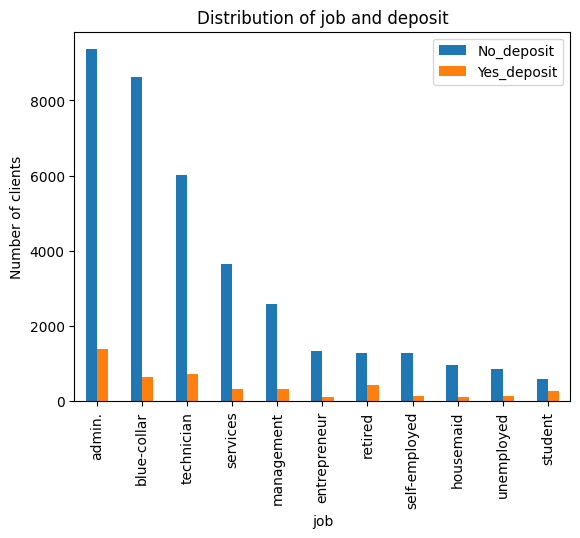

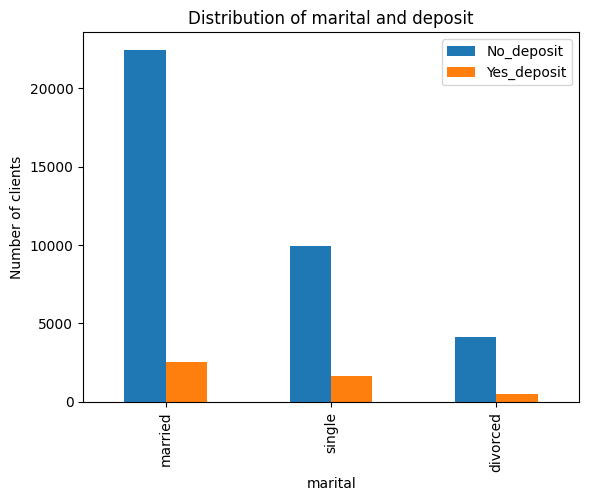

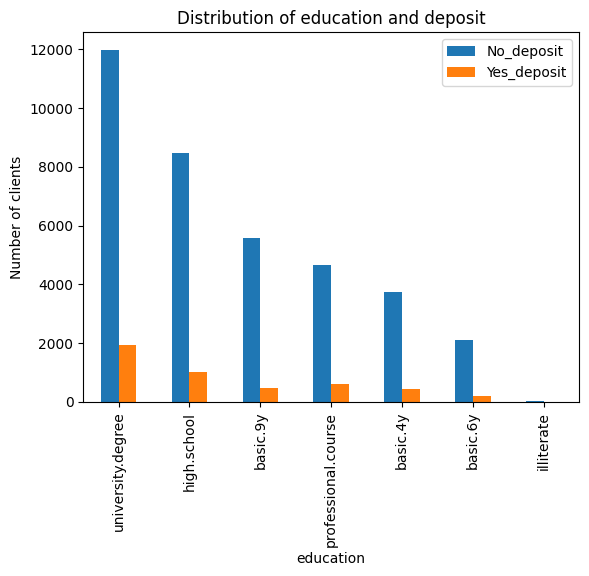

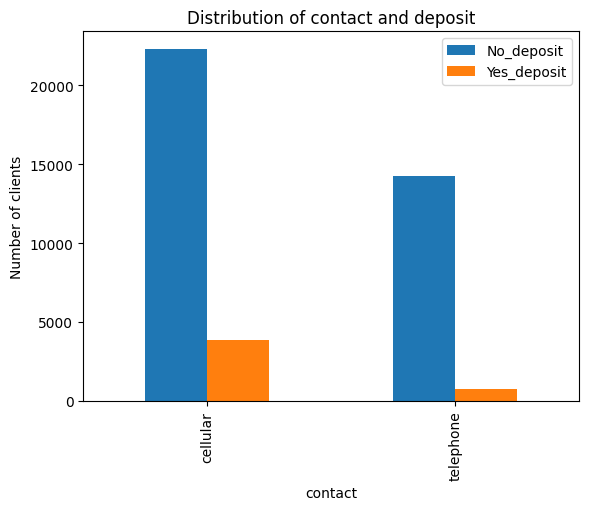

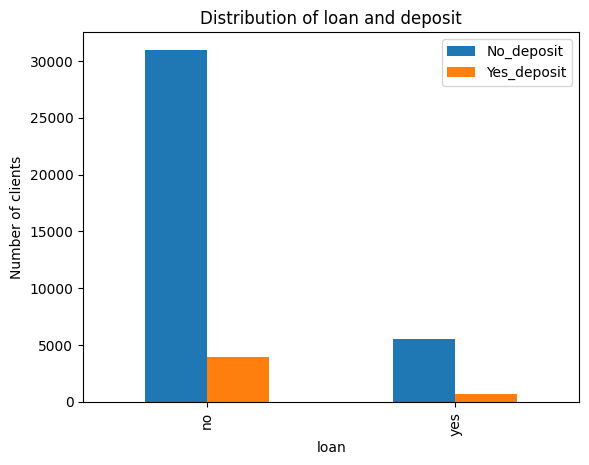

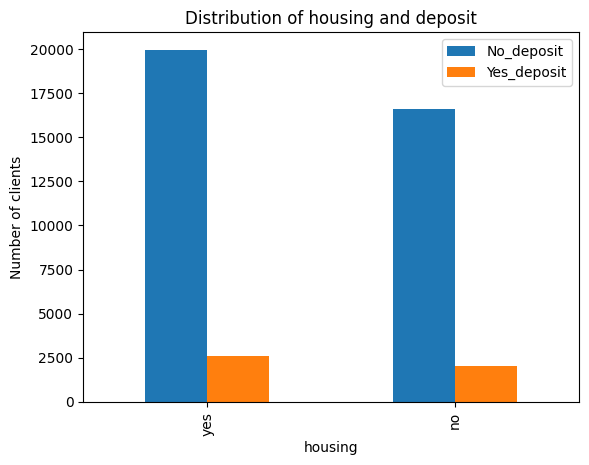

In [48]:
plot_bar('job'), 
plot_bar('marital'), 
plot_bar('education'), 
plot_bar('contact'), 
plot_bar('loan'), 
plot_bar('housing')

**Primary analysis of several categorical features reveals:**

###### Administrative staff and technical specialists opened the deposit most of all. 
###### In relative terms, a high proportion of pensioners and students might be mentioned as well.
###### Although in absolute terms married consumers more often agreed to the service, in relative terms the single was responded better.
###### Best communication channel is secullar.
###### The difference is evident between consumers who already use the services of banks and received a loan.
###### Home ownership does not greatly affect marketing company performance.

**Explore numerical features**

In [49]:
# Convert target variable into numeric
df.y = df.y.map({'no':0, 'yes':1}).astype('uint8')

In [50]:
# Build correlation matrix for numeric columns
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
corr.style.background_gradient(cmap='PuBu')

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,0.030399,-0.066357,-0.324914,0.230181,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


**From correlation matrix we observe next:**

###### higly correlated features (employment rate, consumer confidence index, consumer price index) may describe clients state from different social-economic angles. Their variance might support model capacity for generalization.

**Data cleaning stategy**

In [51]:
# Replacing values with binary ()
df.contact = df.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
df.loan = df.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
df.housing = df.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
df.default = df.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
df.pdays = df.pdays.replace(999, 0) # replace with 0 if not contact 
df.previous = df.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
df.poutcome = df.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 

# change the range of Var Rate
df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
df['emp.var.rate'] = df['emp.var.rate'] * -1
df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index 
df['cons.price.idx'] = (df['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
df['cons.conf.idx'] = df['cons.conf.idx'] * -1

# re-scale variables
df['nr.employed'] = np.log2(df['nr.employed']).astype('uint8')
df['cons.price.idx'] = np.log2(df['cons.price.idx']).astype('uint8')
df['cons.conf.idx'] = np.log2(df['cons.conf.idx']).astype('uint8')
df.age = np.log(df.age)

# less space
df.euribor3m = df.euribor3m.astype('uint8')
df.campaign = df.campaign.astype('uint8')
df.pdays = df.pdays.astype('uint8')

# fucntion to One Hot Encoding
def encode(df, col):
    return pd.concat([df, pd.get_dummies(col, prefix=col.name, dtype=int)], axis=1)

# One Hot encoding of 3 variable 
df = encode(df, df.job)
df = encode(df, df.month)
df = encode(df, df.day_of_week)

# Drop tranfromed features
df.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

**Drop the dublicates**

In [52]:
df.drop_duplicates(inplace=True) 

**Target encoding for two categorical feature**

In [53]:
df = encode(df, df['marital'])
df = encode(df, df['education'])
df.drop(['marital', 'education'], axis=1, inplace=True)
numeric_dataset = df.copy()
numeric_dataset.drop('y', axis=1, inplace=True)

**Check numerical data set**

In [54]:
y = df['y']  # Define the target variable
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 43 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,default,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,...,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree
0,4.025352,1,0,0,0,1,0,0,0,9,...,0,1,0,1,0,0,0,0,0,0
1,4.043051,1,0,0,0,1,0,0,0,9,...,0,1,0,0,0,0,1,0,0,0
2,3.610918,1,1,0,0,1,0,0,0,9,...,0,1,0,0,0,0,1,0,0,0


(38175, 50)

(38175,)

'We observe 41175 rows and 43 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

In [55]:
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=42)

In [56]:
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'check the shape of splitted train and test sets'

(30540, 50)

(30540,)

(7635, 50)

(7635,)

In [57]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [58]:
print("=== Support Vector Machine (SVM) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

=== Support Vector Machine (SVM) ===
Accuracy: 0.8882776686313032
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6681
           1       0.66      0.21      0.32       954

    accuracy                           0.89      7635
   macro avg       0.78      0.60      0.63      7635
weighted avg       0.87      0.89      0.86      7635



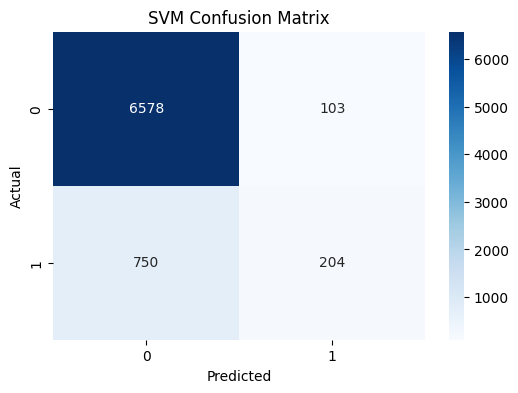

In [59]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [60]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [61]:
print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 0.8901113294040602
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6681
           1       0.70      0.21      0.33       954

    accuracy                           0.89      7635
   macro avg       0.80      0.60      0.63      7635
weighted avg       0.87      0.89      0.86      7635



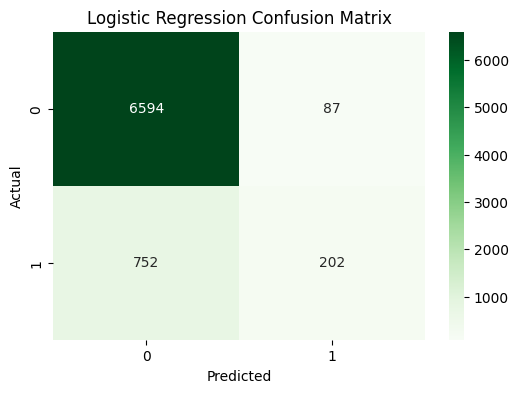

In [62]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [63]:
joblib.dump(lr_model, "model.pkl")
joblib.dump(svm_model, "preprocessor.pkl")

['preprocessor.pkl']

In [100]:
sample_clients = pd.DataFrame([
    {'age': 41, 'contact': 1, 'loan': 0, 'housing': 0, 'default': 1, 'pdays': 7, 'previous': 1, 'poutcome': 1,
     'emp.var.rate': 1.1, 'cons.price.idx': 92.0, 'cons.conf.idx': -36.0, 'nr.employed': 5099.1,
     'euribor3m': 4.5, 'campaign': 1, 'job': 'blue-collar', 'month': 'may', 'day_of_week': 'mon',
     'marital': 'single', 'education': 'university.degree'},
    
    {'age': 60, 'contact': 0, 'loan': 0, 'housing': 1, 'default': 1, 'pdays': 0, 'previous': 0, 'poutcome': 0,
     'emp.var.rate': -1.8, 'cons.price.idx': 93.0, 'cons.conf.idx': -40.0, 'nr.employed': 5191.0,
     'euribor3m': 1.3, 'campaign': 2, 'job': 'retired', 'month': 'jun', 'day_of_week': 'tue',
     'marital': 'married', 'education': 'basic.9y'},
    
    {'age': 45, 'contact': 1, 'loan': 0, 'housing': 0, 'default': 1, 'pdays': 7, 'previous': 1, 'poutcome': 0,
     'emp.var.rate': -1.1, 'cons.price.idx': 93.5, 'cons.conf.idx': -30.0, 'nr.employed': 5076.2,
     'euribor3m': 2.1, 'campaign': 3, 'job': 'admin.', 'month': 'jul', 'day_of_week': 'wed',
     'marital': 'divorced', 'education': 'high.school'},
    
    {'age': 35, 'contact': 0, 'loan': 1, 'housing': 1, 'default': 1, 'pdays': 0, 'previous': 0, 'poutcome': 0,
     'emp.var.rate': 1.4, 'cons.price.idx': 94.0, 'cons.conf.idx': -45.0, 'nr.employed': 5017.5,
     'euribor3m': 3.3, 'campaign': 4, 'job': 'technician', 'month': 'aug', 'day_of_week': 'thu',
     'marital': 'single', 'education': 'professional.course'},
    
    {'age': 52, 'contact': 1, 'loan': 0, 'housing': 1, 'default': 1, 'pdays': 3, 'previous': 1, 'poutcome': 0,
     'emp.var.rate': -0.1, 'cons.price.idx': 92.9, 'cons.conf.idx': -38.0, 'nr.employed': 5095.0,
     'euribor3m': 2.0, 'campaign': 3, 'job': 'management', 'month': 'may', 'day_of_week': 'fri',
     'marital': 'married', 'education': 'university.degree'},
    
    {'age': 29, 'contact': 1, 'loan': 0, 'housing': 0, 'default': 1, 'pdays': 0, 'previous': 0, 'poutcome': 0,
     'emp.var.rate': -3.4, 'cons.price.idx': 91.0, 'cons.conf.idx': -50.0, 'nr.employed': 4965.0,
     'euribor3m': 1.1, 'campaign': 1, 'job': 'unemployed', 'month': 'nov', 'day_of_week': 'mon',
     'marital': 'single', 'education': 'basic.6y'},
    
    {'age': 48, 'contact': 1, 'loan': 0, 'housing': 0, 'default': 1, 'pdays': 999, 'previous': 1, 'poutcome': 1,
     'emp.var.rate': -1.2, 'cons.price.idx': 93.2, 'cons.conf.idx': -39.8, 'nr.employed': 5020.0,
     'euribor3m': 3.2, 'campaign': 7, 'job': 'services', 'month': 'dec', 'day_of_week': 'wed',
     'marital': 'unknown', 'education': 'unknown'},
    
    {'age': 33, 'contact': 0, 'loan': 0, 'housing': 0, 'default': 1, 'pdays': 999, 'previous': 1, 'poutcome': 0,
     'emp.var.rate': -0.8, 'cons.price.idx': 92.6, 'cons.conf.idx': -42.0, 'nr.employed': 5080.0,
     'euribor3m': 3.1, 'campaign': 2, 'job': 'blue-collar', 'month': 'apr', 'day_of_week': 'thu',
     'marital': 'married', 'education': 'basic.4y'},
    
    {'age': 41, 'contact': 0, 'loan': 1, 'housing': 0, 'default': 1, 'pdays': 0, 'previous': 0, 'poutcome': 0,
     'emp.var.rate': 0.2, 'cons.price.idx': 93.6, 'cons.conf.idx': -37.0, 'nr.employed': 5040.0,
     'euribor3m': 2.8, 'campaign': 3, 'job': 'self-employed', 'month': 'sep', 'day_of_week': 'fri',
     'marital': 'single', 'education': 'university.degree'},
    
    {'age': 38, 'contact': 1, 'loan': 0, 'housing': 1, 'default': 1, 'pdays': 0, 'previous': 0, 'poutcome': 0,
     'emp.var.rate': 0.5, 'cons.price.idx': 93.9, 'cons.conf.idx': -33.0, 'nr.employed': 5055.0,
     'euribor3m': 2.3, 'campaign': 2, 'job': 'entrepreneur', 'month': 'oct', 'day_of_week': 'tue',
     'marital': 'married', 'education': 'high.school'}
])

In [101]:
# === 1. Apply log to age
sample_clients['age'] = np.log(sample_clients['age'])

# === 2. Apply binary mappings
sample_clients['pdays'] = sample_clients['pdays'].replace(999, 0)
sample_clients['previous'] = sample_clients['previous'].apply(lambda x: 1 if x > 0 else 0).astype('uint8')
sample_clients['contact'] = sample_clients['contact'].astype('uint8')
sample_clients['loan'] = sample_clients['loan'].astype('uint8')
sample_clients['housing'] = sample_clients['housing'].astype('uint8')
sample_clients['default'] = sample_clients['default'].astype('uint8')
sample_clients['poutcome'] = sample_clients['poutcome'].astype('uint8')

# === 3. Transform numerical features
sample_clients['emp.var.rate'] = sample_clients['emp.var.rate'].apply(lambda x: x * -0.0001 if x > 0 else x)
sample_clients['emp.var.rate'] *= -1
sample_clients['emp.var.rate'] = sample_clients['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

sample_clients['cons.price.idx'] = (sample_clients['cons.price.idx'] * 10).astype('uint8')
sample_clients['cons.price.idx'] = np.log2(sample_clients['cons.price.idx']).astype('uint8')

sample_clients['cons.conf.idx'] *= -1
sample_clients['cons.conf.idx'] = np.log2(sample_clients['cons.conf.idx']).astype('uint8')

sample_clients['nr.employed'] = np.log2(sample_clients['nr.employed']).astype('uint8')
sample_clients['euribor3m'] = sample_clients['euribor3m'].astype('uint8')
sample_clients['campaign'] = sample_clients['campaign'].astype('uint8')
sample_clients['pdays'] = sample_clients['pdays'].astype('uint8')

# === 4. One-hot encode job, month, day_of_week
def encode(df, col):
    return pd.concat([df, pd.get_dummies(col, prefix=col.name, dtype=int)], axis=1)

sample_clients = encode(sample_clients, sample_clients['job'])
sample_clients = encode(sample_clients, sample_clients['month'])
sample_clients = encode(sample_clients, sample_clients['day_of_week'])

# ✅ DO NOT DROP 'marital' and 'education' yet
sample_clients.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

sample_clients = encode(sample_clients, sample_clients['marital'])
sample_clients = encode(sample_clients, sample_clients['education'])
sample_clients.drop(['marital', 'education'], axis=1, inplace=True)

for col in numeric_dataset.columns:
    if col not in sample_clients.columns:
        sample_clients[col] = 0

sample_clients = sample_clients[numeric_dataset.columns]



In [102]:
print(sample_clients.head(3))

        age  default  housing  loan  contact  campaign  pdays  previous  \
0  3.713572        1        0     0        1         1      7         1   
1  4.094345        1        1     0        0         2      0         0   
2  3.806662        1        0     0        1         3      7         1   

   poutcome  emp.var.rate  ...  marital_divorced  marital_married  \
0         1             9  ...                 0                0   
1         0             0  ...                 0                1   
2         0             0  ...                 1                0   

   marital_single  education_basic.4y  education_basic.6y  education_basic.9y  \
0               1                   0                   0                   0   
1               0                   0                   0                   1   
2               0                   0                   0                   0   

   education_high.school  education_illiterate  education_professional.course  \
0               

In [103]:
predictions_01 = svm_model.predict(sample_clients)
predictions_02 = lr_model.predict(sample_clients)

print(predictions_01, predictions_02)

[0 0 1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
